## K-means clustering with PCA

We are interested in the impact of external variables on the coronavirus pandemic. To further investigate, we collected data from multiple source to create our unique dataset which include information on the Covid-19 cases and deaths, weather information, population and mobility across counties in the United States. 

To get an intuition about the structure of the complete data set, we applied K-means clustering to identify potential subgroups in the data. Clustering of US counties may reveal homogeneities and unprecedented connections among the counties. 

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 4000
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../.')
from lib import get_data

In [64]:
df = get_data.get_model_data(date_range=(0,7), pred_day=10)

# select only numeric data, drop fips column, drop rows with NA
dfnum_with_index = df._get_numeric_data().drop(['fips'],axis=1).dropna()

# Standardize the data
scaler = preprocessing.StandardScaler()
dfnum = pd.DataFrame(scaler.fit_transform(dfnum_with_index), columns=dfnum_with_index.columns)

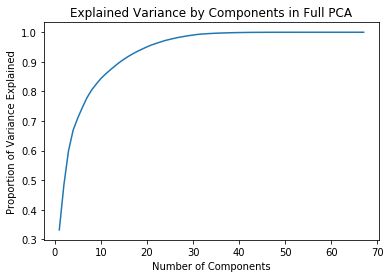

In [65]:
# employed PCA to reduce the number of features as well as the noise in our data set. 
full_pca = PCA(random_state=109).fit(dfnum)

# Calculate the cumulative sum of the variance explained by each component.
cum_exp_var = np.cumsum(full_pca.explained_variance_ratio_)
plt.plot(np.arange(len(cum_exp_var))+1, cum_exp_var)
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Explained Variance by Components in Full PCA');

In [66]:
cum_exp_var_df = pd.DataFrame([cum_exp_var], columns=np.arange(len(cum_exp_var))+1, index=['Variance Explained'])
cum_exp_var_df.columns.name = 'Number of PCs'
cum_exp_var_df

Number of PCs            1         2         3         4         5         6   \
Variance Explained  0.33218  0.484553  0.599525  0.669112  0.710118  0.745654   

Number of PCs             7        8         9         10  ...        58  \
Variance Explained  0.778691  0.80459  0.824595  0.843261  ...  0.999999   

Number of PCs             59   60   61   62   63   64   65   66   67  
Variance Explained  0.999999  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

[1 rows x 67 columns]

In [67]:
# choose the number of components cover 80% of variance --> n_components = 8
final_pca = PCA(8, random_state=109).fit(dfnum)
dfnum_pca = final_pca.transform(dfnum)

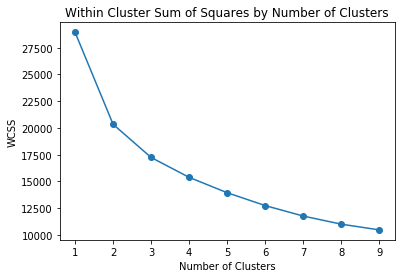

In [68]:
# cross validate number of clusters
wcss = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=109).fit(dfnum_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10), wcss,'-o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Within Cluster Sum of Squares by Number of Clusters');

In [69]:
# elbow method --> n_clusters = 4
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=109).fit(dfnum_pca)

In [70]:
dfnum_pca_kmeans = pd.concat([dfnum.reset_index(drop = True),pd.DataFrame(dfnum_pca)],axis =1)
dfnum_pca_kmeans.columns.values[-4:] = ['Principal Component 1','Principal Component 2','Principal Component 3','Principal Component 4']
dfnum_pca_kmeans['Kmeans Cluster'] = kmeans_final.labels_
dfnum_pca_kmeans.head()

cases    deaths  cldCvrMin  cldCvrAvg  cldCvrMax  dewPtMin  dewPtAvg  \
0 -0.519417 -0.025768  -0.968423  -0.582393   0.235206  0.883918  0.968625   
1 -0.512901  0.541658  -0.961487  -0.550729   0.370467  0.527934  0.561149   
2 -0.871275 -0.593195  -0.940677  -0.602749   0.526537  0.344290  0.424066   
3 -0.050274  2.385795  -0.968423  -0.969155  -0.590234  0.780710  0.749360   
4 -0.382584  0.541658  -0.968423  -0.487399   0.755441  1.138496  1.223919   

   dewPtMax  feelsLikeMin  feelsLikeAvg  ...  day_10_delta_deaths         0  \
0  1.065056      1.160095      1.285567  ...            -0.497416  5.856374   
1  0.666038      0.848662      0.885000  ...            -0.497416  4.110932   
2  0.567760      0.593281      0.728841  ...            -0.497416  3.574087   
3  0.685908      0.642405      0.891259  ...             1.211146  4.817810   
4  1.324982      1.438778      1.495865  ...            -0.497416  7.049329   

          1         2         3  Principal Component 1  Principal Component 2  \
0  2.324635 -0.663894  0.152439              -0.226930              -0.503658   
1  3.000520 -1.152254 -0.191781               0.588828              -0.996618   
2  3.179112 -0.820523 -0.784834               0.631670              -1.238587   
3  3.193035 -4.273034 -1.180483              -0.569624              -0.597240   
4  3.283710 -1.603097 -0.668563              -0.230361              -0.965875   

   Principal Component 3  Principal Component 4  Kmeans Cluster  
0              -0.695674              -0.217274               2  
1              -0.300914              -0.179673               0  
2              -0.097668              -0.718468               0  
3               0.990040               1.305678               0  
4              -1.586521               1.461136               2  

[5 rows x 76 columns]

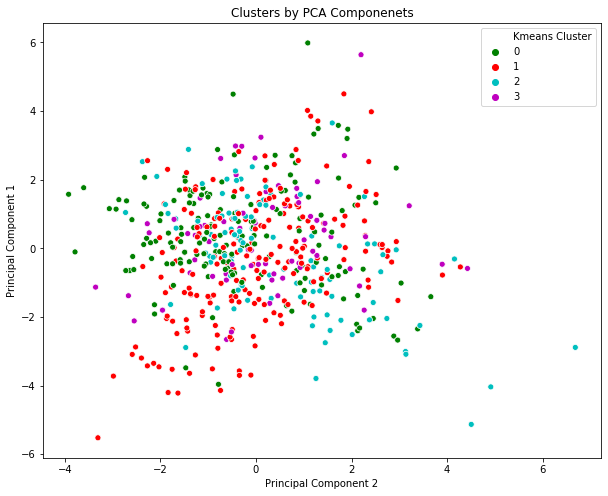

In [71]:
x_axis = dfnum_pca_kmeans['Principal Component 2']
y_axis = dfnum_pca_kmeans['Principal Component 1']
plt.figure(figsize =(10,8))
sns.scatterplot(x_axis, y_axis, hue = dfnum_pca_kmeans['Kmeans Cluster'], palette = ['g','r','c','m'])
plt.title('Clusters by PCA Componenets')
plt.show()

In [72]:
# what counties are in each cluster?
def county_clusters(df = df, df_with_index = dfnum_with_index, kmeans_final = kmeans_final, n_clusters =4, n_counties = 10):
    df = df.iloc[df_with_index.index]
    df['Kmeans Cluster'] = kmeans_final.labels_
    df['state_county'] = df.county +', ' +df.state
    mylist = []
    cluster_names = []
    for i in range(0, n_clusters):
        cluster = df[df['Kmeans Cluster']==i].sort_values(by=['cases'],ascending=False).state_county[0:n_counties].values
        cluster_names.append('Cluster ' + str(i))
        mylist.append(list(cluster))
    county_cluster = pd.DataFrame(mylist)
    county_cluster = county_cluster.transpose()
    county_cluster.columns = cluster_names
    return county_cluster
county_clusters()

Cluster 0                 Cluster 1  \
0            maricopa, arizona           wayne, michigan   
1        san diego, california  providence, rhode island   
2  mecklenburg, north carolina          macomb, michigan   
3              fulton, georgia          orange, new york   
4               hamilton, ohio         oakland, michigan   
5        st. charles, missouri         ocean, new jersey   
6                clark, nevada         carroll, maryland   
7             kern, california         union, new jersey   
8              bartow, georgia      milwaukee, wisconsin   
9       durham, north carolina         shelby, tennessee   

                    Cluster 2                   Cluster 3  
0         miami-dade, florida       westchester, new york  
1               travis, texas           el paso, colorado  
2          dougherty, georgia              weld, colorado  
3  charleston, south carolina          benton, washington  
4       hillsborough, florida               pima, arizona  
5               denton, texas  san bernardino, california  
6              tarrant, texas           larimer, colorado  
7         palm beach, florida              lubbock, texas  
8            broward, florida    middlesex, massachusetts  
9    richland, south carolina               canyon, idaho

Clustering with all collected variables did not demonstrate well-separated clusters. 

The above table shows clusters of counties with most average confirmed cases in the first week following emergence of 10 confirmed cases. Counties in each cluster are generally geographically close to each other. Cluster 0 represents counties in Rocky Mountain areas and southern states. Cluster 1 includes counties mostly from New England area and the Great Lakes area. Cluster 2 represents counties from southern states. Cluster 3 is a mix of counties in Rocky Mountain areas, southern states and New England areas. 

Due to the large amount of weather information in the complete data set, the clustering is biased by the weather information, and the clustering results can be interpreted as regions with different climates. To eliminate the influence of weather information, we applied K-means clustering again to the variables show significance in Generalized Linear Model.

In [73]:
glm_variables = ['windSpdMin',
       'cases', 'precip', 'deaths', 'cldCvrMin',
       'parks_percent_change_from_baseline', 'presTendAvg', 'snowfall',
       'snowDepth', 'spcHumMin','grocery_and_pharmacy_percent_change_from_baseline']

In [74]:
df_glm_variable_name = df[glm_variables].dropna()
df_glm = df_glm_variable_name
df_glm.head()

windSpdMin   cases    precip  deaths  cldCvrMin  \
1     1.487500  20.875  0.102500   0.500     0.0000   
11    0.729167  21.000  0.049375   1.000     0.0625   
12    0.675000  14.125  0.070000   0.000     0.2500   
13    0.125000  13.125  0.040000   0.000     0.0000   
14    0.025000  29.875  0.015000   2.625     0.0000   

    parks_percent_change_from_baseline   presTendAvg  snowfall  snowDepth  \
1                           -33.500000  1.250000e-02       0.0        0.0   
11                           41.714286  1.250000e-02       0.0        0.0   
12                           -4.000000 -6.938894e-18       0.0        0.0   
13                           25.000000  6.938894e-18       0.0        0.0   
14                          -23.000000 -5.000000e-02       0.0        0.0   

    spcHumMin  grocery_and_pharmacy_percent_change_from_baseline  
1    7.250000                                            -12.500  
11   6.622917                                              4.500  
12   6.250000                                             -4.125  
13   7.137500                                             -1.000  
14   7.062500                                             -3.875

In [75]:
scaler = preprocessing.StandardScaler().fit(df_glm)
df_glm = pd.DataFrame(scaler.fit_transform(df_glm), columns=df_glm.columns)
full_pca_glm = PCA(random_state=109).fit(df_glm)

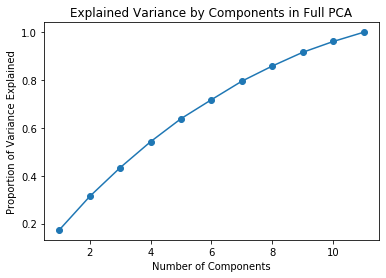

In [76]:
# standardization
scaler = preprocessing.StandardScaler().fit(df_glm)
df_glm = pd.DataFrame(scaler.fit_transform(df_glm), columns=df_glm.columns)

#dimension reducation with PCA
full_pca_glm = PCA(random_state=109).fit(df_glm)

# Calculate the cumulative sum of the variance explained by each component.
cum_exp_var = np.cumsum(full_pca_glm.explained_variance_ratio_)
plt.plot(np.arange(len(cum_exp_var))+1, cum_exp_var,'-o')
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Explained Variance by Components in Full PCA');

In [77]:
final_pca_glm = PCA(7, random_state=0).fit(df_glm)
glm_pca = final_pca_glm.transform(df_glm)

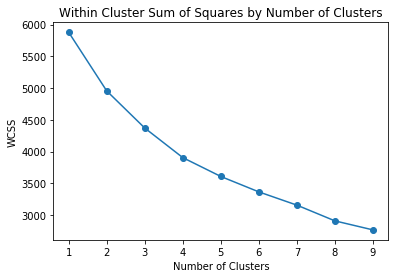

In [78]:
# cross validate number of clusters
wcss = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42).fit(glm_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10), wcss,'-o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Within Cluster Sum of Squares by Number of Clusters');

In [90]:
kmeans_final_glm = KMeans(n_clusters=4, init='k-means++', random_state=109).fit(glm_pca)
glm_pca_kmeans = pd.concat([df_glm.reset_index(drop = True),pd.DataFrame(glm_pca)],axis =1)
glm_pca_kmeans.columns.values[-4:] = ['Principal Component 1','Principal Component 2','Principal Component 3','Principal Component 4']
glm_pca_kmeans['Kmeans Cluster'] = kmeans_final_glm.labels_
glm_pca_kmeans.head()

windSpdMin     cases    precip    deaths  cldCvrMin  \
0   -0.093869 -0.433708  0.143158 -0.015455  -0.910341   
1   -0.660336 -0.426810 -0.498720  0.569643  -0.903354   
2   -0.700798 -0.806196 -0.249520 -0.600552  -0.882394   
3   -1.111642 -0.861379 -0.611993 -0.600552  -0.910341   
4   -1.186341  0.062944 -0.914053  2.471208  -0.910341   

   parks_percent_change_from_baseline  presTendAvg  snowfall  snowDepth  \
0                           -1.172130     0.579711 -0.329461  -0.193476   
1                            1.176928     0.579711 -0.329461  -0.193476   
2                           -0.250799     0.316341 -0.329461  -0.193476   
3                            0.654915     0.316341 -0.329461  -0.193476   
4                           -0.844199    -0.737141 -0.329461  -0.193476   

   spcHumMin  grocery_and_pharmacy_percent_change_from_baseline         0  \
0   0.677689                                          -0.201815 -1.411689   
1   0.447003                                           1.267927 -0.964961   
2   0.309818                                           0.522249 -1.427030   
3   0.636304                                           0.792422 -1.522346   
4   0.608713                                           0.543862 -1.066912   

          1         2  Principal Component 1  Principal Component 2  \
0  0.530968  0.263495               0.086585              -0.014097   
1 -1.076649 -1.565038               0.113957              -0.052187   
2 -0.287522 -0.333020              -0.477441              -0.663828   
3 -0.703053 -0.901663              -0.491927              -0.885086   
4 -0.012306 -0.872546               2.745537              -0.524998   

   Principal Component 3  Principal Component 4  Kmeans Cluster  
0              -0.026937               0.501890               1  
1              -0.220458               0.358516               2  
2               0.124324               0.276326               1  
3               0.078794               0.130704               1  
4              -0.012679               0.163749               1

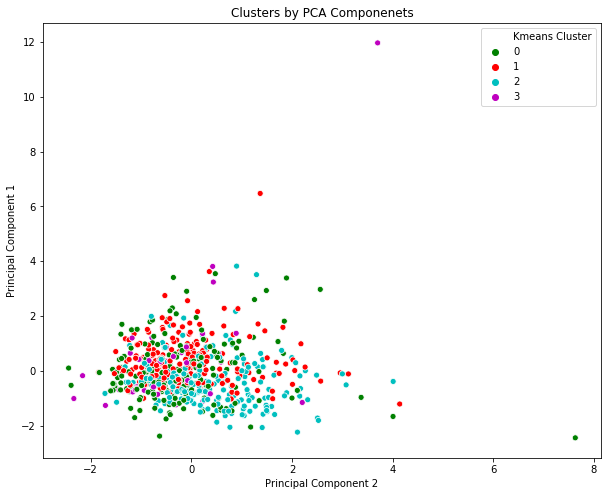

In [91]:
x_axis = glm_pca_kmeans['Principal Component 2']
y_axis = glm_pca_kmeans['Principal Component 1']
plt.figure(figsize =(10,8))
sns.scatterplot(x_axis, y_axis, hue = glm_pca_kmeans['Kmeans Cluster'], palette = ['g','r','c','m'])
plt.title('Clusters by PCA Componenets')
plt.show()

In [92]:
county_clusters(df = df, df_with_index = df_glm_variable_name, kmeans_final = kmeans_final_glm, n_clusters =4, n_counties = 10)


Cluster 0                   Cluster 1  \
0           wayne, michigan         miami-dade, florida   
1  providence, rhode island          dougherty, georgia   
2          macomb, michigan  charleston, south carolina   
3          orange, new york       hillsborough, florida   
4         oakland, michigan  san bernardino, california   
5         ocean, new jersey         palm beach, florida   
6         carroll, maryland             fulton, georgia   
7         union, new jersey            kern, california   
8      milwaukee, wisconsin              henry, georgia   
9         shelby, tennessee            broward, florida   

                 Cluster 2                 Cluster 3  
0        maricopa, arizona        onondaga, new york  
1    westchester, new york          king, washington  
2    san diego, california  worcester, massachusetts  
3        suffolk, new york        dutchess, new york  
4  plymouth, massachusetts          denver, colorado  
5        el paso, colorado         boulder, colorado  
6   bristol, massachusetts        saratoga, new york  
7   fairfield, connecticut          ulster, new york  
8        essex, new jersey             lake, indiana  
9       rockland, new york     schenectady, new york

Clusters are still not well-separated with the reduced data set, but clustering results rely less on the geographical regions and climatic segmentations across the US. 

Cluster 0 and cluster 1 still show strong geographical groupings, where counties in cluster 0 are mostly from New England and Great Lake areas, and counties in cluster 1 are mostly from California and southern states. Cluster 2 and Cluster 3 both include counties from New England area and Rocky Mountain area. The subgroupping of counties in cluster 2 and cluster 3 indicates homogeneity of within cluster counties at a high dimensional feature space. While counties in New England area and Rocky Mountain area are very different in terms of climate, there might be similarities in population, mobility, and other features that related to the spread of the pandemic.